<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/GP15_Defining_Watermass_Subtypes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install py_pcha
!pip install gsw

     |████████████████████████████████| 2.4MB 6.3MB/s 


Grab the data

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-05-04 18:38:47--  https://docs.google.com/uc?export=download&confirm=AOZc&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr
Resolving docs.google.com (docs.google.com)... 173.194.215.113, 173.194.215.138, 173.194.215.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.215.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-2o-docs.googleusercontent.com/docs/securesc/g3epde00rvia8k88edsiq2k8pehqevkq/a19em2qv0fr83klbt6kc72nns5frek1e/1620153525000/06203730782251856755/14695444489471527099Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download [following]
--2021-05-04 18:38:47--  https://doc-04-2o-docs.googleusercontent.com/docs/securesc/g3epde00rvia8k88edsiq2k8pehqevkq/a19em2qv0fr83klbt6kc72nns5frek1e/1620153525000/06203730782251856755/14695444489471527099Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download
Resolving doc-04-2o-docs.googleusercontent.com (doc-04-2o-docs.googleusercontent.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Conne

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [20]:
colnames_subset = ["latitude", 'longitude', 'year', 'depth',
                   'pressure', 'temperature','salinity','oxygen',
                   'silicate', 'nitrate', 'phosphate', 'sigma0']


df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temperature'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temperature"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])

In [24]:
ARCH_ANALYSIS_FEATURES = ["conservative_temperature", "absolute_salinity",
                          "silicate", "NO", "PO"]
ALL_FEATURES_TO_AVERAGE = ARCH_ANALYSIS_FEATURES+["phosphate", "nitrate", "oxygen"]

feature_weights = {"conservative_temperature": 56.0,
                   "absolute_salinity": 80.0,
                   "silicate": 3.0,
                   "NO": 5.0,
                   "PO": 5.0}

print("Standardizing feature values")
#Let's standardize each column by subtracting mean,
# dividing by standard deviation and multiplying by the feature weights.
# Call it a 'features' dataframe
#keep track of mean and std in order to do inverse transform
colname_to_mean = {}
colname_to_std = {} 
for colname in ARCH_ANALYSIS_FEATURES:
  vals = np.array(df[colname])
  #use nanmean and nanstd to ignore nan values for now
  mean = np.nanmean(vals)
  std = np.nanstd(vals)
  colname_to_mean[colname] = mean
  colname_to_std[colname] = std
  df['standardized_'+colname] = feature_weights[colname]*(vals-mean)/std

#Since imputation takes a while on such a large dataset, we
# will just drop rows that have missing values
print("Proportions of missing values:")
print(np.sum(np.isnan(df)) / len(df))
print("Original number of rows:", len(df))
df = df.dropna()
print("Remaining rows after dropping missing vals:",len(df))

TRANSFORM_MEANS = np.array([colname_to_mean[colname]
                           for colname in ARCH_ANALYSIS_FEATURES])
TRANSFORM_STDS = np.array([(colname_to_std[colname]/feature_weights[colname])
                           for colname in ARCH_ANALYSIS_FEATURES])


#function to map features back to original space
def map_features_back(features):
  return features*TRANSFORM_STDS[None,:] + TRANSFORM_MEANS[None,:]




Standardizing feature values
Proportions of missing values:
latitude                                 0.0
longitude                                0.0
year                                     0.0
depth                                    0.0
pressure                                 0.0
temperature                              0.0
salinity                                 0.0
oxygen                                   0.0
silicate                                 0.0
nitrate                                  0.0
phosphate                                0.0
sigma0                                   0.0
NO                                       0.0
PO                                       0.0
potential_temperature                    0.0
absolute_salinity                        0.0
conservative_temperature                 0.0
standardized_conservative_temperature    0.0
standardized_absolute_salinity           0.0
standardized_silicate                    0.0
standardized_NO                         

On water mass AAIW
Ranges: {'lat_min': -51.0, 'lat_max': -47.0, 'lon_min': -120.0, 'lon_max': 150.0, 'sig0_min': 27.01, 'sig0_max': 27.1}


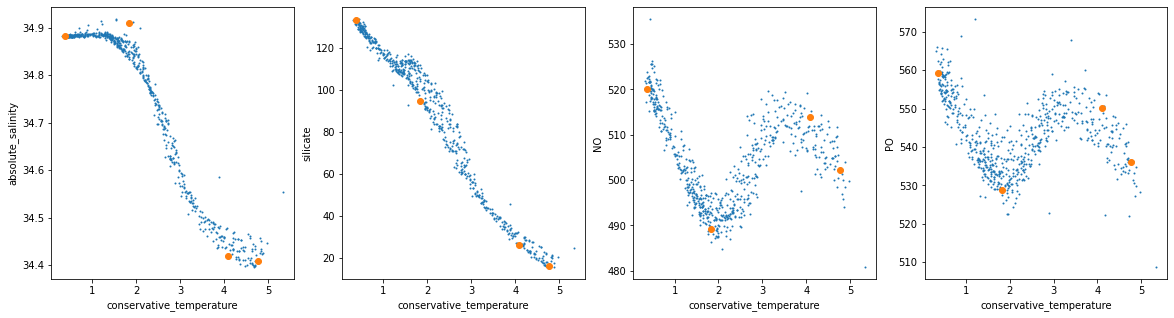

On water mass NPIW
Ranges: {'lat_min': 34.0, 'lat_max': 37.0, 'lon_min': 140.0, 'lon_max': 153.0, 'sig0_min': 26.5, 'sig0_max': 27.4}


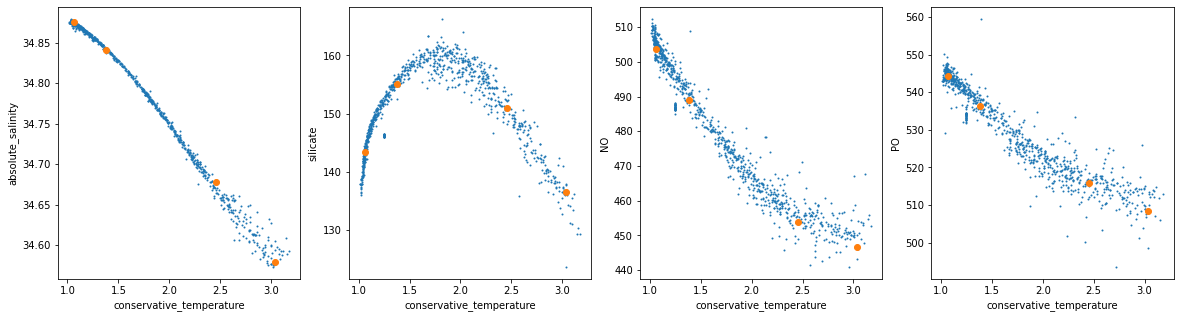

In [46]:
from py_pcha import PCHA


def run_archetype_analysis(df, num_endmembers):
    features = np.array([np.array(df["standardized_"+col])
                      for col in ARCH_ANALYSIS_FEATURES]).transpose((1,0))
    origspace_features = np.array([np.array(df[col]) for col in
                                   ALL_FEATURES_TO_AVERAGE]).transpose((1,0))

    XC, S, C, SSE, varexpl = PCHA(X=features.T, noc=num_endmembers,
                                  verbose=False)
    archetype_features = np.array(XC).T #becomes archtetypes X features
    obs_combos_giving_archetypes = np.array(C).T #archetypes X obs combos

    origspace_archetypes = obs_combos_giving_archetypes@origspace_features

    #Make scatterplots
    fig,ax = plt.subplots(nrows=1, ncols=len(ARCH_ANALYSIS_FEATURES)-1,
                          figsize=(20,5))
    pltnum = 0
    for featureidx1 in [0]:#range(len(ALL_FEATURES_TO_AVERAGE)):
        for featureidx2 in range(featureidx1+1, len(ALL_FEATURES_TO_AVERAGE)):
            if ((ALL_FEATURES_TO_AVERAGE[featureidx1]
                 in ARCH_ANALYSIS_FEATURES) and
                (ALL_FEATURES_TO_AVERAGE[featureidx2]
                 in ARCH_ANALYSIS_FEATURES)):
                plt.sca(ax[pltnum])
                plt.scatter(origspace_features[:,featureidx1],
                            origspace_features[:,featureidx2], s=1)
                plt.scatter(origspace_archetypes[:,featureidx1],
                            origspace_archetypes[:,featureidx2])
                plt.xlabel(ALL_FEATURES_TO_AVERAGE[featureidx1])
                plt.ylabel(ALL_FEATURES_TO_AVERAGE[featureidx2]) 
                pltnum += 1
    plt.show()

    return pandas.DataFrame(dict([(colname, origspace_archetypes[:,idx])
                        for idx,colname in enumerate(ALL_FEATURES_TO_AVERAGE)]))
    

filter_conditions = {
    "AAIW": {"lat_min":-51.0, "lat_max":-47.0,
             "lon_min":-120.0, "lon_max":150.0,
             "sig0_min":27.01, "sig0_max":27.1},
    "NPIW": {"lat_min":34.0, "lat_max":37.0,
             "lon_min":140.0, "lon_max":153.0,
             "sig0_min":26.5, "sig0_max":27.4}
    
}

def filter_rows(df, lat_min, lat_max, lon_min, lon_max, sig0_min, sig0_max):
  return df[(df["latitude"] >= lat_min) &
            (df["latitude"] <= lat_max) &
            (df["longitude"] >= lon_min) &
            (df["longitude"] <= lon_max) &
            (df["sigma0"] >= sig0_min) &
            (df["sigma0"] >= sig0_max)
            ]

NUM_ARCHETYPES = 4

watermass_to_archetypes = {}

for watermass in filter_conditions:
  print("On water mass", watermass)
  print("Ranges:", filter_conditions[watermass])
  watermass_rows = filter_rows(df=df, **filter_conditions[watermass])
  watermass_archetypes = run_archetype_analysis(df=watermass_rows,
                                                num_endmembers=NUM_ARCHETYPES)
  watermass_to_archetypes[watermass] = watermass_archetypes

In [43]:
watermass_to_archetypes["AAIW"]

,conservative_temperature,absolute_salinity,silicate,NO,PO,phosphate,nitrate,oxygen
0,1.833035,34.911134,94.389172,489.175293,528.460449,2.237337,31.766744,181.673216
1,4.761795,34.407596,16.537958,502.252265,536.054493,1.909129,27.077768,240.139467
2,0.375949,34.881711,132.962509,519.935806,559.249854,2.276054,32.383704,206.461553
3,4.081212,34.420948,26.507668,513.999262,550.158105,2.088282,29.702983,226.474388


In [47]:
watermass_to_archetypes["NPIW"]

,conservative_temperature,absolute_salinity,silicate,NO,PO,phosphate,nitrate,oxygen
0,1.066128,34.875787,143.446524,503.739056,544.394020,2.466582,35.295995,162.073824
1,2.454697,34.677904,150.959342,453.948231,515.999990,2.981596,41.332190,53.852635
2,1.380954,34.841026,155.012232,489.042118,536.315428,2.667121,37.823395,122.911653
3,3.033806,34.578824,136.559422,446.705914,508.504875,2.998672,41.631734,43.710724
